In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

import pandas as pd
import numpy as np
import os
import seaborn as sns

# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [3]:
file_path = os.path.join(os.curdir,'data','Kopie van BastianLewisData.xlsx')

df_vars = pd.read_excel(file_path,sheet_name='VariableSelection')
df = pd.read_excel(file_path,sheet_name='Result 1')

var_drop = list(df_vars['Name'][df_vars['Status'] == 'Drop'])

df.drop(labels = var_drop,  axis= 1, inplace = True)

df["Huidig/Laatste functie"].fillna("", inplace=True)
df['Meest trotste project'].fillna("", inplace=True)

df['text'] = df["Huidig/Laatste functie"] +" : " + df['Meest trotste project']

In [43]:
df = df[df['starter']==1][["Huidig/Laatste functie",'Meest trotste project','Motivatie']]

In [49]:
df['text'] = df['Motivatie'].fillna("")

In [50]:
#df['text'] = df["Huidig/Laatste functie"] +" : " + df['Meest trotste project']

In [51]:
df['processed_text'] = df['text'].apply(lambda x: x.lower())  # Convert to lowercase
df['processed_text'] = df['processed_text'].str.replace('[^\w\s]', '') 
df['processed_text'] = df['processed_text'].str.replace('\n', ' ')  # Remove punctuation

<ipython-input-51-4e5f63c1b004>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed_text'] = df['processed_text'].str.replace('[^\w\s]', '')


### Look for buzz words and bigrams, trigrams

In [52]:
from collections import Counter
import pandas as pd
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords (if not already done)
nltk.download('stopwords')
stop_words = set(stopwords.words('dutch'))

# Tokenize the text and count word frequencies
words = ' '.join(df['processed_text']).lower().split()
word_counts = Counter(words)

# Remove punctuation and filter out stopwords
filtered_words = [word for word in words if word.isalpha() and word not in stop_words]

# Count word frequencies after filtering
filtered_word_counts = Counter(filtered_words)
most_common_filtered_words = filtered_word_counts.most_common(200)
print(most_common_filtered_words)

[('technische', 16), ('alleen', 16), ('sta', 14), ('open', 14), ('branche', 14), ('enof', 14), ('gerelateerd', 14), ('hieraan', 14), ('werken', 7), ('techniek', 6), ('handen', 5), ('werk', 5), ('graag', 5), ('nieuwe', 4), ('gewerkt', 4), ('uitdaging', 4), ('vind', 4), ('jaar', 3), ('wel', 3), ('elektrotechniek', 3), ('mee', 3), ('leren', 3), ('lijkt', 3), ('echt', 3), ('leuk', 3), ('zitten', 3), ('horeca', 2), ('tijd', 2), ('waarin', 2), ('groeien', 2), ('bezig', 2), ('gehad', 2), ('stap', 2), ('leven', 2), ('merkte', 2), ('erg', 2), ('beter', 2), ('vaardigheden', 2), ('affiniteit', 2), ('willen', 2), ('uitbreiden', 2), ('afgelopen', 2), ('nooit', 2), ('gedaan', 2), ('baan', 2), ('afgerond', 2), ('hoop', 2), ('dragen', 2), ('kennis', 2), ('zonnepanelenmonteur', 2), ('fysiek', 2), ('achter', 2), ('bureau', 2), ('beviel', 2), ('verschillende', 2), ('tof', 2), ('continu', 1), ('veranderd', 1), ('intressant', 1), ('blijft', 1), ('tien', 1), ('weg', 1), ('slaan', 1), ('nieuw', 1), ('vakgebi

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\peter\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
pd.DataFrame(most_common_filtered_words).to_excel('buzzwords_motivatie.xlsx')

In [12]:
df['processed_text'].apply(lambda)

0       [(reiniger, in), (in, de), (de, technische), (...
1       [(technician, werkervaring), (werkervaring, en...
2       [(expediteur, badkamer), (badkamer, zelf), (ze...
3       [(rioolmonteur, ik), (ik, heb), (heb, een), (e...
4       [(procesoperator, diploma), (diploma, behaald)...
                              ...                        
9938                            [(techniek, installatie)]
9939                                                   []
9940                                                   []
9941                                                   []
9942                                                   []
Name: bigrams, Length: 9943, dtype: object

In [15]:
df['bigrams']

0       [(reiniger, in), (in, de), (de, technische), (...
1       [(technician, werkervaring), (werkervaring, en...
2       [(expediteur, badkamer), (badkamer, zelf), (ze...
3       [(rioolmonteur, ik), (ik, heb), (heb, een), (e...
4       [(procesoperator, diploma), (diploma, behaald)...
                              ...                        
9938                            [(techniek, installatie)]
9939                                                   []
9940                                                   []
9941                                                   []
9942                                                   []
Name: bigrams, Length: 9943, dtype: object

In [17]:
def get_bigrams(row):
    words = row['processed_text'].split()
    return [(words[i], words[i + 1]) for i in range(len(words) - 1)]

df['bigrams'] = df.apply(get_bigrams, axis=1)
all_bigrams = [bigram for sublist in df['bigrams'] for bigram in sublist]

# Count word frequencies after filtering
bigrams_counts = Counter(all_bigrams)
most_common_filtered_words = bigrams_counts.most_common(10)
print(most_common_filtered_words)

[(('ik', 'heb'), 603), (('in', 'de'), 280), (('heb', 'ik'), 214), (('de', 'techniek'), 194), (('ik', 'ben'), 147), (('van', 'een'), 128), (('geen', 'ervaring'), 101), (('heb', 'geen'), 99), (('ik', 'hoop'), 88), (('binnen', 'de'), 86)]


In [5]:
# Assuming 'text_data' is your pandas DataFrame with open text variables and 'target' is your binary target variable
# Step 1: Text preprocessing (assuming 'text' is the name of your text column)
df['processed_text'] = df['text'].apply(lambda x: x.lower())  # Convert to lowercase
df['processed_text'] = df['processed_text'].str.replace('[^\w\s]', '') 
df['processed_text'] = df['processed_text'].str.replace('\n', ' ')  # Remove punctuation

# Step 2: Feature extraction using TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(df['processed_text'])
y = df['starter']

# Step 3: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<ipython-input-5-c1a4d0b898f7>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed_text'] = df['processed_text'].str.replace('[^\w\s]', '')


In [6]:
df['processed_text'].iloc[1]

'technician  werkervaring en nevenactiviteiten   beroepen  monteur elektrische installatie tesla  juni 2015  heden  40 pw  leidinggevende opleiden van nieuwe collegas uitvoeren van complexe en nauwkeurige elektromechanische debug reparatie revisie en reparatie van elektromechanische componenten of elektromotoren werken met en helpen bij het ontwikkelen van gespecialiseerde armaturen testapparatuur en procedures data verzamelen het bijwerken en onderhouden van elektronische en schriftelijke gegevens    elektromonteur elektrische installatiesrandstad  november 2012 juni 2015  40 pw  installatieselektrische systemen inspecteren op fouten testen en onderhouden van systemenhet oplossen van storingen aan systemen    monteur laag en middenspanningsnetten    kabelwerkerbaas bv  januari 2008 december 2011  40 pw  werkzaamheden in installaties van 10kv tot 50kv   montage en revisie werkzaamheden ms en hs af en instellen van equipment zoals vermogensschakelaars'

## Logistic regression

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1952
           1       0.00      0.00      0.00        37

    accuracy                           0.98      1989
   macro avg       0.49      0.50      0.50      1989
weighted avg       0.96      0.98      0.97      1989

Confusion Matrix:


c:\Users\peter\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\peter\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\peter\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


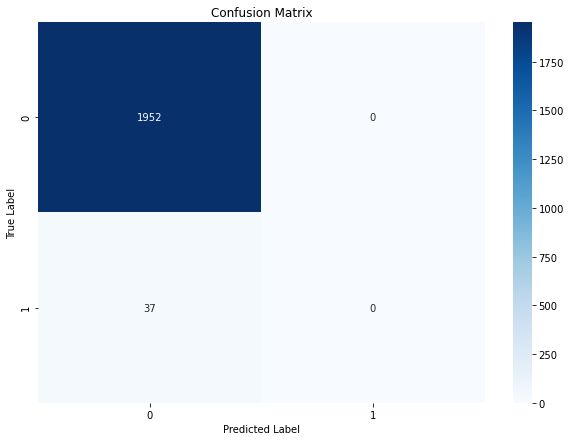

In [7]:
# Step 4: Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 5: Predict and evaluate
y_pred = model.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Print confusion matrix
print('Confusion Matrix:')
# Assuming your target variable has classes 'class_0', 'class_1', ..., you can replace these with your actual class names
class_names = df['starter'].unique()

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)

## Random forest classifier

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1952
           1       0.00      0.00      0.00        37

    accuracy                           0.98      1989
   macro avg       0.49      0.50      0.50      1989
weighted avg       0.96      0.98      0.97      1989

Confusion Matrix:


c:\Users\peter\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\peter\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\peter\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


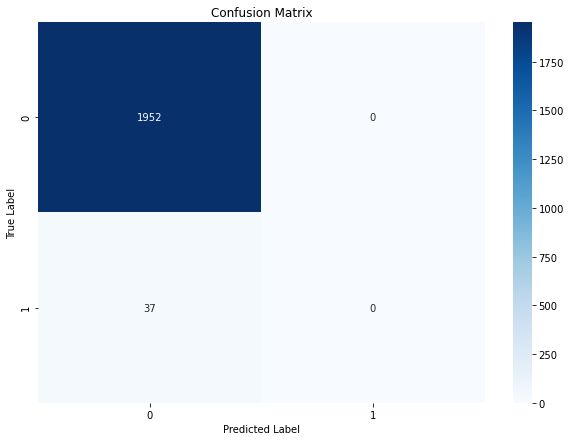

In [8]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Print confusion matrix
print('Confusion Matrix:')
# Assuming your target variable has classes 'class_0', 'class_1', ..., you can replace these with your actual class names
class_names = df['starter'].unique()

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)

## BalancedRandomForestClassifier

c:\Users\peter\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\peter\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\peter\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.17      0.28      1952
           1       0.02      0.81      0.04        37

    accuracy                           0.18      1989
   macro avg       0.50      0.49      0.16      1989
weighted avg       0.96      0.18      0.28      1989



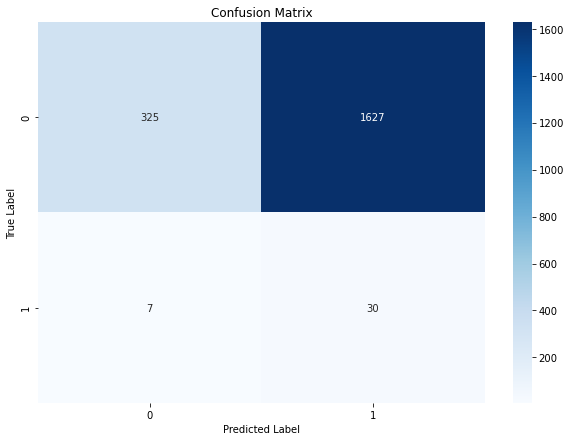

In [9]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Initialize and train the Balanced Random Forest model
brf = BalancedRandomForestClassifier(n_estimators=80, random_state=42)
brf.fit(X_train, y_train)

# Make predictions
y_pred = brf.predict(X_test)

# Evaluate the model
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names)


## Use SMOTE for resampling

Accuracy: 0.28
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.27      0.42      1952
           1       0.02      0.70      0.03        37

    accuracy                           0.28      1989
   macro avg       0.50      0.49      0.23      1989
weighted avg       0.96      0.28      0.42      1989



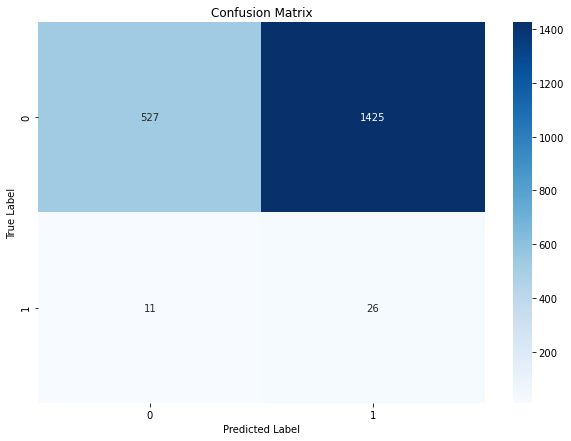

Precision: 0.96
Recall: 0.28
F1 Score: 0.42


In [10]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Initialize and train the model with class weights
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_resampled, y_resampled)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Assuming your target variable has classes 'class_0', 'class_1', ..., you can replace these with your actual class names
class_names = df['starter'].unique()

plot_confusion_matrix(cm, class_names)

# Calculate and print performance metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


## BalancedRandomForest with RFE 

In [11]:
# Initialize the model
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# Apply RFE
rfe = RFE(estimator=brf, n_features_to_select=10)  # Adjust n_features_to_select as needed
rfe.fit(X_train, y_train)

# Transform the dataset with selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Train the Balanced Random Forest with selected features
brf.fit(X_train_rfe, y_train)

# Evaluate the model
y_pred_rfe = brf.predict(X_test_rfe)
y_proba_rfe = brf.predict_proba(X_test_rfe)[:, 1]

# Print the classification report and plot confusion matrix
print('Classification Report with RFE:')
print(classification_report(y_test, y_pred_rfe))

cm_rfe = confusion_matrix(y_test, y_pred_rfe)
plot_confusion_matrix(cm_rfe, class_names)

# Calculate and print additional metrics
roc_auc_rfe = roc_auc_score(y_test, y_proba_rfe)
print(f'ROC-AUC with RFE: {roc_auc_rfe:.2f}')


c:\Users\peter\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\peter\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\peter\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\peter

KeyboardInterrupt: 

## Xgboost

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1952
           1       0.11      0.14      0.12        37

    accuracy                           0.96      1989
   macro avg       0.55      0.56      0.55      1989
weighted avg       0.97      0.96      0.97      1989



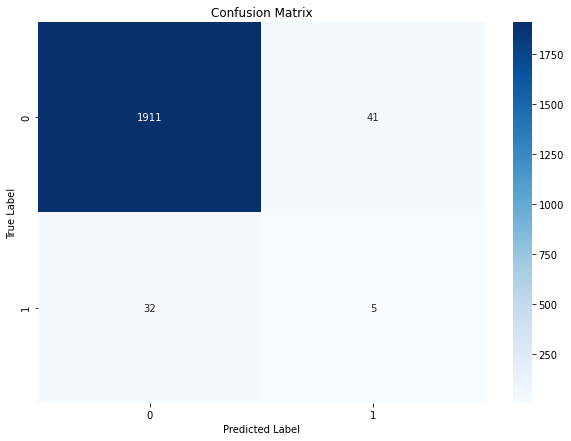

In [12]:
import xgboost as xgb

# Initialize and train the XGBoost model with class weights
model = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names)

## Adjust categorization threshold

<ipython-input-30-55b6963d1995>:13: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.26      0.42      1952
           1       0.02      0.70      0.03        37

    accuracy                           0.27      1989
   macro avg       0.50      0.48      0.23      1989
weighted avg       0.96      0.27      0.41      1989



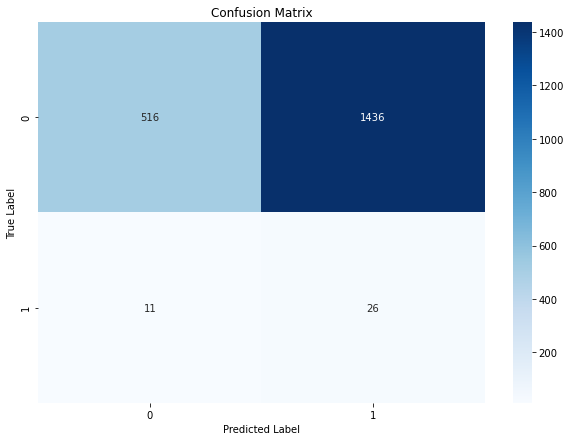

In [30]:
# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_resampled, y_resampled)

# Predict probabilities
y_proba = rf.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find the best threshold based on desired precision/recall trade-off
# Example: maximizing the F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

best_threshold = .4
# Make predictions with the best threshold
y_pred = (y_proba >= best_threshold).astype(int)

# Evaluate the model
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.27      0.42      1952
           1       0.02      0.70      0.03        37

    accuracy                           0.28      1989
   macro avg       0.50      0.49      0.23      1989
weighted avg       0.96      0.28      0.42      1989



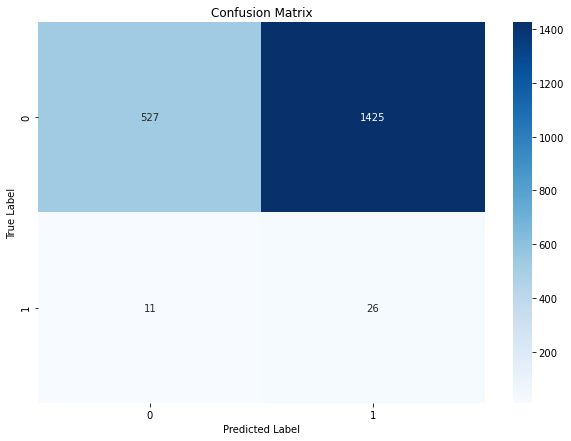

In [58]:
best_threshold = .503
# Make predictions with the best threshold
y_pred = (y_proba >= best_threshold).astype(int)

# Evaluate the model
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names)

<ipython-input-25-d65bd1959c82>:16: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1952
           1       0.11      0.14      0.12        37

    accuracy                           0.96      1989
   macro avg       0.55      0.56      0.55      1989
weighted avg       0.97      0.96      0.97      1989



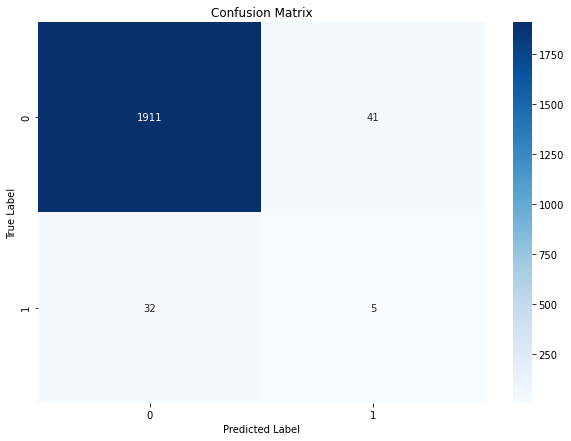

In [25]:
import xgboost as xgb

# Initialize and train the XGBoost model with class weights
model = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)
model.fit(X_train, y_train)


# Predict probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find the best threshold based on desired precision/recall trade-off
# Example: maximizing the F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

# Make predictions with the best threshold
y_pred = (y_proba >= best_threshold).astype(int)

# Evaluate the model
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names)